C:\Users\Alex\Documents\GitHub\MetPy\metpy\mapping\mpmap.py:34: UserWarning: data_type not specified, will assume txt based on filename.
  warnings.warn(message)


ValueError: Unrecognized parameter: variable

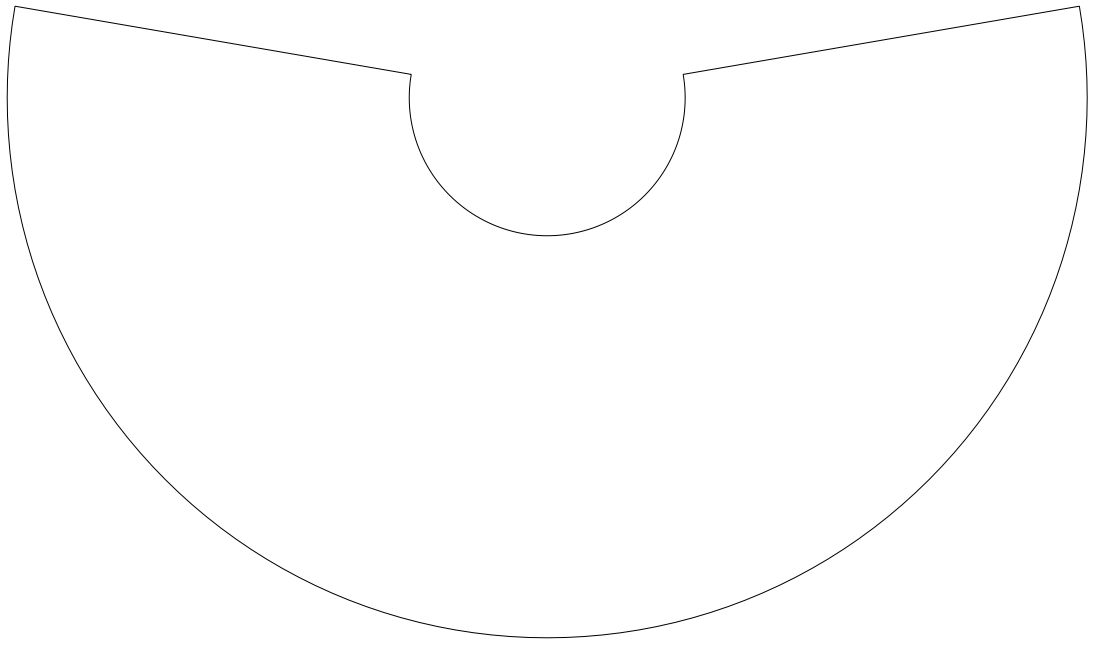

In [2]:
from metpy.mapping.mpmap import GridMap
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import cartopy.crs as ccrs

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

options = {"map_params": {"bbox": {"north": 50, "south": 20, "east": -70, "west": -120},
                          "features": ["coastlines", "ocean", "countries", "states"]},
           "variable": "Precipitable_water_entire_atmosphere_single_layer_ens",
           "time": datetime.utcnow(),
           "data_location": ("http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GEFS/"
                             "Global_1p0deg_Ensemble/members/catalog.html?dataset="
                             "grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best")
           }



view = plt.axes([0, 0, 1, 1], projection=to_proj)
    
sfc_map = GridMap(options)

view = sfc_map.draw_map(view)

In [30]:
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime

gefs = TDSCatalog("http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GEFS/Global_1p0deg_Ensemble"
                   "/members/catalog.html?dataset=grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best")

best_ds = list(gefs.datasets.values())[0]

ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

query = ncss.query()

query.lonlat_box(north=50, south=20, east=-70, west=-120).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Precipitable_water_entire_atmosphere_single_layer_ens')

data = ncss.get_data(query)
print(list(data.variables))

temp_var = data.variables['Precipitable_water_entire_atmosphere_single_layer_ens']

# Time variables can be renamed in GRIB collections. Best to just pull it out of the
# coordinates attribute on temperature
time_name = temp_var.coordinates.split()[1]
time_var = data.variables[time_name]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

['Precipitable_water_entire_atmosphere_single_layer_ens', 'reftime1', 'time1', 'ens', 'lat', 'lon']


C:\Users\Alex\Anaconda3\envs\unidata3\lib\site-packages\siphon-0+unknown-py3.4.egg\siphon\catalog.py:72: UserWarning: URL http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/catalog.html?dataset=grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best returned HTML. Changing to: http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/catalog.xml?dataset=grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best


In [60]:
time_var

<class 'netCDF4._netCDF4.Variable'>
float64 time1(time1)
    units: Hour since 2016-06-30T00:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [53]:
import numpy as np
from netCDF4 import num2date

# Get the actual data values and remove any size 1 dimensions
temp_vals = temp_var[0, 0, :, :]
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_var[:].squeeze(), time_var.units)

# Convert temps to Fahrenheit from Kelvin
#temp_vals = temp_vals * 1.8 - 459.67

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

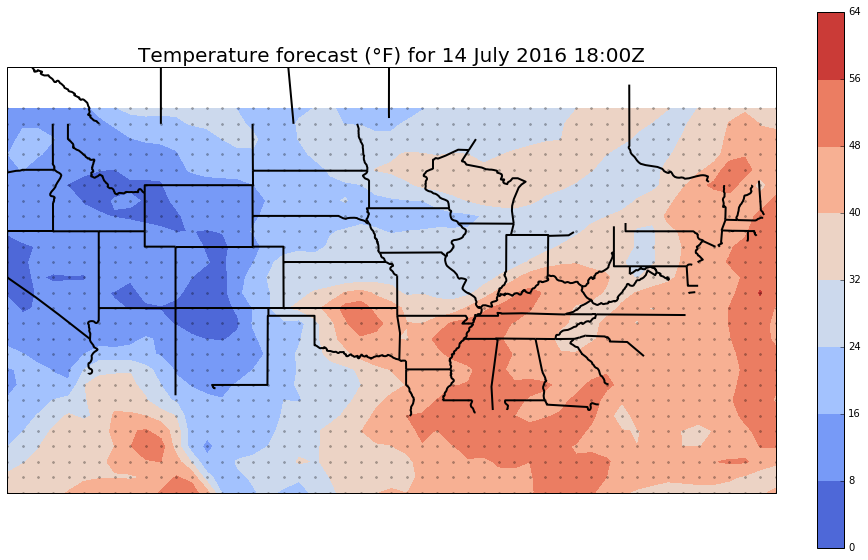

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120., -70., 25, 50])

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=2)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_vals, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2,
        alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none');